# Temperature and humidity dataset

This dataset was created using a raspberry pi connected to a DHT11 temperature and humidity sensor which was set up to log the room temperature every 15 minutes over a set period and print the results to a CSV file. The CSV file was used to create an SQL database. [Click here](https://github.com/blaze21777/RaspberryPi-Projects/tree/master/DHT11_Humidity_Sensor) for the Raspberry pi project and CSV. [Click here](https://github.com/blaze21777/SQL-Projects/tree/master/Temperature_Humidity_Dataset) for the SQL project.

### The Dataset

* id SERIAL,            
* date TIMESTAMP ,
* year SMALLINT ,
* month SMALLINT ,
* day SMALLINT ,
* time TIME ,
* temperature NUMERIC, (degrees celsius)
* humidity NUMERIC,    (percentage %)
* PRIMARY KEY (id)

The full date was split to make it easier to work with the individual parts if required. 

### Project Objective
The goal of the project was to discover if there is any meaningful relationship between temperature, humidity and time within the room. 

### Key Background information
* Humidity indicates the likelihood for precipitation, dew, or fog to be present.
* Humidity depends on the temperature and pressure of the system of interest.
    - The same amount of water vapor results in higher relative humidity in cool air than warm air.
    - The amount of water vapor needed to achieve saturation increases as the temperature increases.
* **Relative humidity was measured**
    - Relative humidity, often expressed as a percentage, indicates a present state of absolute humidity relative to a maximum humidity given the same temperature.
* [Source](https://en.wikipedia.org/wiki/Humidity)

In [89]:
# Import packages 
import os
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.sql import text
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Load database

In [90]:
# name of the postgresql database
database_name = "temp_data"
user = "postgres:admin@localhost:5432"
connection = f"postgresql+psycopg2://{user}/{database_name}"
engine = create_engine(connection)
print(sqlalchemy.__version__)

1.4.40


In [159]:
# Get data file
data_path = os.path.abspath(
    # Need to go up two levels to where all github repos are located
    "..\..\RaspberryPi-Projects\DHT11_Humidity_Sensor\\temperature_data.csv"
)
data_path

'c:\\Users\\Stephen\\Documents\\GitHub_Repositories\\RaspberryPi-Projects\\DHT11_Humidity_Sensor\\temperature_data.csv'

In [160]:
# SQL to update table from local csv file
statement = text(
    f"""
        CREATE TABLE IF NOT EXISTS temp_data (
            id SERIAL,
            date TIMESTAMP ,
            year SMALLINT ,
            month SMALLINT ,
            day SMALLINT ,
            time TIME ,
            temperature NUMERIC,
            humidity NUMERIC,
            PRIMARY KEY (id)
        );

        COPY temp_data(Date, Year, Month, Day, Time, Temperature, Humidity)
        FROM '{data_path}'
        DELIMITER ','
        CSV HEADER;
    """
)

In [161]:
with engine.connect() as con:
    con.execute(statement)

In [93]:
# Run SQL query and store in dataframe
df_temperature_data = pd.read_sql(
    # Humidity cannot exceed 100%
    "SELECT * FROM temp_data WHERE humidity <= 100",
    engine,
)
df_temperature_data.head()

,id,date,year,month,day,time,temperature,humidity
0,1,2022-07-18 16:48:32.839391,2022,7,18,16:48:32,33.0,25.0
1,2,2022-07-18 17:03:33.364782,2022,7,18,17:03:33,34.0,28.0
2,3,2022-07-18 17:18:33.890008,2022,7,18,17:18:33,34.0,27.0
3,5,2022-07-18 17:48:34.940317,2022,7,18,17:48:34,34.0,28.0
4,6,2022-07-18 18:03:35.465421,2022,7,18,18:03:35,34.0,27.0


In [94]:
# id column will not provide any useful information
df_temperature_data.drop("id", axis=1, inplace=True)
df_temperature_data.head()

,date,year,month,day,time,temperature,humidity
0,2022-07-18 16:48:32.839391,2022,7,18,16:48:32,33.0,25.0
1,2022-07-18 17:03:33.364782,2022,7,18,17:03:33,34.0,28.0
2,2022-07-18 17:18:33.890008,2022,7,18,17:18:33,34.0,27.0
3,2022-07-18 17:48:34.940317,2022,7,18,17:48:34,34.0,28.0
4,2022-07-18 18:03:35.465421,2022,7,18,18:03:35,34.0,27.0


# Exploratory Data Analysis

In [95]:
# Displays the names of columns, the data types they contain,
# and whether they have any missing values.
df_temperature_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56402 entries, 0 to 56401
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         56402 non-null  datetime64[ns]
 1   year         56402 non-null  int64         
 2   month        56402 non-null  int64         
 3   day          56402 non-null  int64         
 4   time         56402 non-null  object        
 5   temperature  56402 non-null  float64       
 6   humidity     56402 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 3.0+ MB


In [96]:
# Another way to check null values
df_temperature_data.isnull().sum()

date           0
year           0
month          0
day            0
time           0
temperature    0
humidity       0
dtype: int64

In [97]:
# Get shape of data 
df_temperature_data.shape

(56402, 7)

In [98]:
# Get the number of unique values in each of the columns 
df_temperature_data.nunique()


date           4896
year              1
month             3
day              31
time           4878
temperature      15
humidity         52
dtype: int64

## Measures of Central Tendency and Dispersion 
- If median and mean are similar it shows that there are few outliers in the data.

In [99]:
# Get mean of temperature
temp_mean = df_temperature_data["temperature"].mean()
temp_mean

27.40411687528811

In [100]:
# Get median of temperature
temp_med = df_temperature_data["temperature"].median()
temp_med

27.0

In [101]:
# Get the mode of temperature
temp_mode = df_temperature_data["temperature"].mode()
temp_mode

0    27.0
Name: temperature, dtype: float64

In [102]:
# Get percentage of temperature values
df_temperature_data["temperature"].value_counts(normalize=True).sort_values(
    ascending=False
) * 100

27.0    19.208539
28.0    17.513563
26.0    13.761923
25.0    13.157335
29.0    11.561647
24.0     6.873870
30.0     5.787029
31.0     4.762242
32.0     3.349172
23.0     1.774760
34.0     0.877628
33.0     0.796071
35.0     0.448566
22.0     0.088649
36.0     0.039006
Name: temperature, dtype: float64

In [103]:
# Get mean of humidity
humid_mean = df_temperature_data["humidity"].mean()

In [104]:
# Get median of humidity
humid_med = df_temperature_data["humidity"].median()

In [105]:
# Get the mode of humidity
humid_mode = df_temperature_data["humidity"].mode()

In [106]:
# Get percentage of humidity values
df_temperature_data["humidity"].value_counts(normalize=True).sort_values(
    ascending=False
) * 100

48.0    5.019326
41.0    4.806567
49.0    4.572533
47.0    4.423602
46.0    4.382823
42.0    4.299493
50.0    4.070778
52.0    3.983901
54.0    3.973263
53.0    3.771143
43.0    3.556611
45.0    3.251658
44.0    3.131095
56.0    3.074359
40.0    3.045991
57.0    2.870466
55.0    2.815503
51.0    2.705578
60.0    2.491046
59.0    2.473317
58.0    2.218006
35.0    1.888231
61.0    1.884685
34.0    1.714478
39.0    1.670154
38.0    1.558455
37.0    1.546044
64.0    1.480444
62.0    1.413070
36.0    1.281869
67.0    1.083295
66.0    1.065565
68.0    1.044289
65.0    1.038970
63.0    0.996419
32.0    0.971597
33.0    0.934364
69.0    0.654232
31.0    0.581540
70.0    0.508847
71.0    0.370554
72.0    0.342186
29.0    0.273040
30.0    0.219850
28.0    0.138293
27.0    0.134747
25.0    0.115244
26.0    0.046098
73.0    0.037233
22.0    0.023049
23.0    0.023049
24.0    0.023049
Name: humidity, dtype: float64

The minimum temperature is 12 which is a very unlikely number due to the average temperatures and a humidity over 100 is impossible since it is a percentage.

In [107]:
# Returns some summary stats such as count,
# mean, std, min, max and data types
display(df_temperature_data[["humidity", "temperature"]].describe())
# df_temperature_data.describe(include=object)

,humidity,temperature
count,56402.000000,56402.000000
mean,49.245080,27.404117
std,9.150991,2.284393
min,22.000000,22.000000
25%,42.000000,26.000000
50%,49.000000,27.000000
75%,56.000000,29.000000
max,73.000000,36.000000


Text(0.5, 1.0, 'Temperature Data')

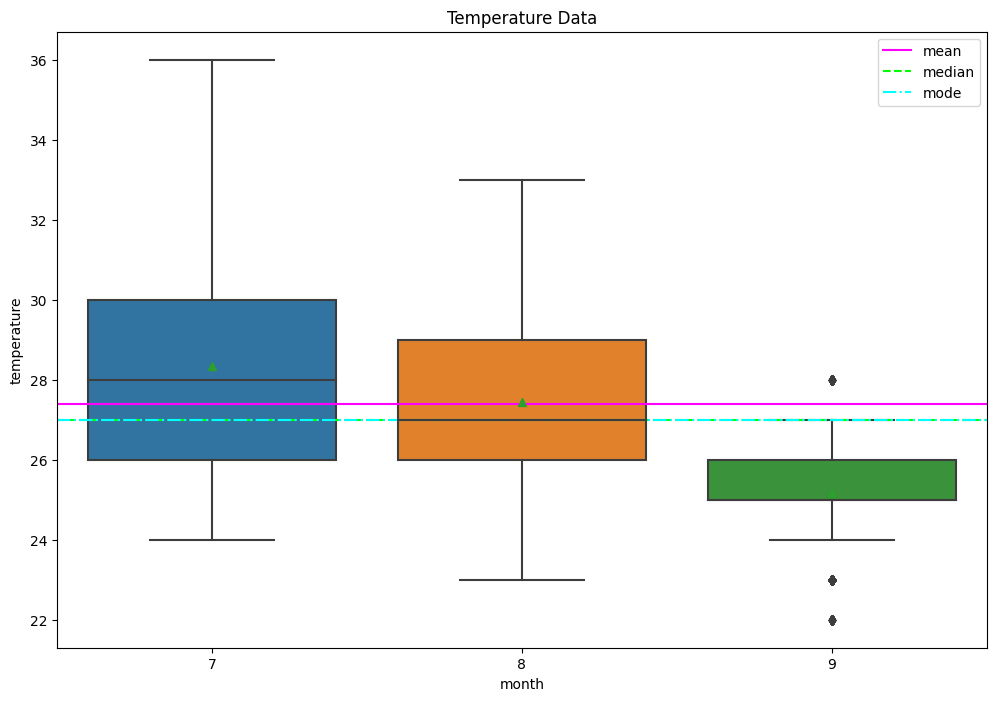

In [108]:
# Plot box plots for temperature over the months
plt.figure(figsize=(12, 8))

sns.boxplot(data=df_temperature_data, x="month", y="temperature", showmeans=True)

plt.axhline(y=temp_mean, color="magenta", linestyle="solid", label="mean")
plt.axhline(y=temp_med, color="lime", linestyle="dashed", label="median")
plt.axhline(y=int(temp_mode), color="cyan", linestyle="dashdot", label="mode")

plt.legend()
plt.title("Temperature Data")

Text(0.5, 1.0, 'Humidity Data')

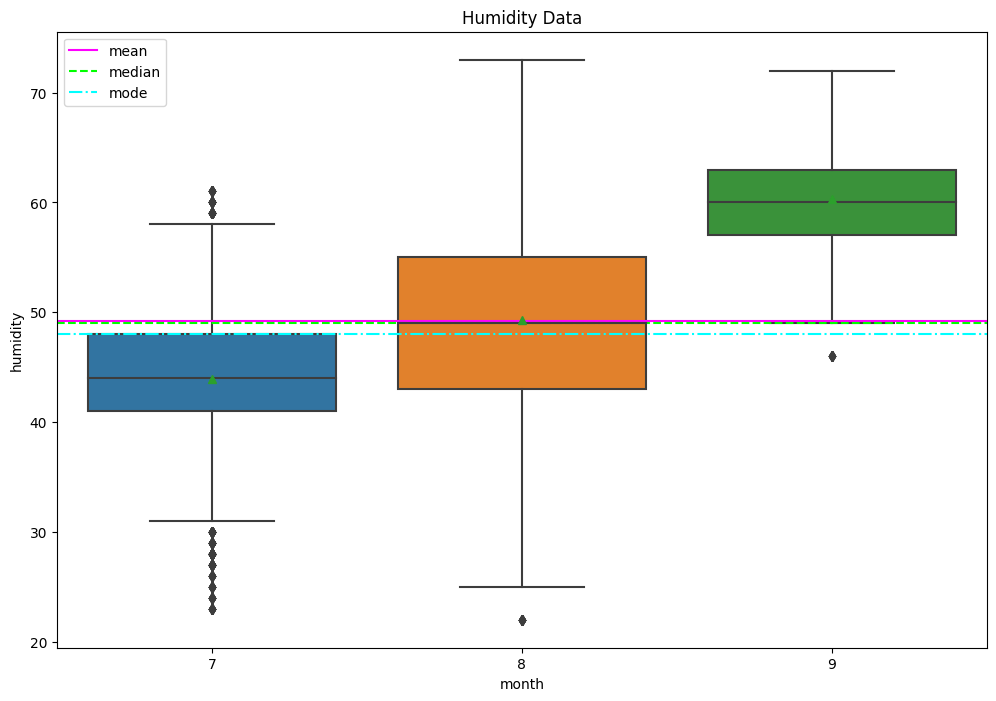

In [109]:
# Plot box plots for humidity over the months
plt.figure(figsize=(12, 8))

sns.boxplot(data=df_temperature_data, x="month", y="humidity", showmeans=True)

plt.axhline(y=humid_mean, color="magenta", linestyle="solid", label="mean")
plt.axhline(y=humid_med, color="lime", linestyle="dashed", label="median")
plt.axhline(y=int(humid_mode), color="cyan", linestyle="dashdot", label="mode")

plt.legend()
plt.title("Humidity Data")

## Measures of Dispersion 

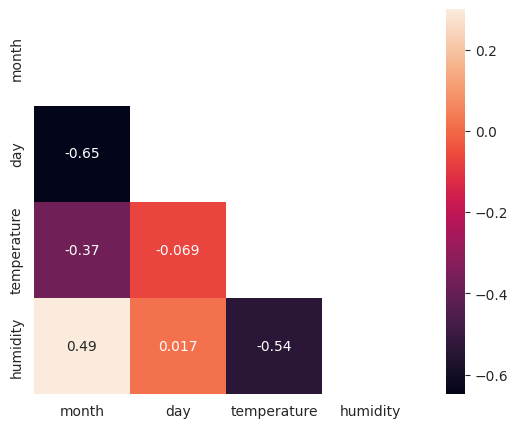

In [110]:
# year shows only nan
corr = df_temperature_data.drop("year", axis=1).corr()

# Plot half of matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, annot=True, vmax=0.3, square=True)

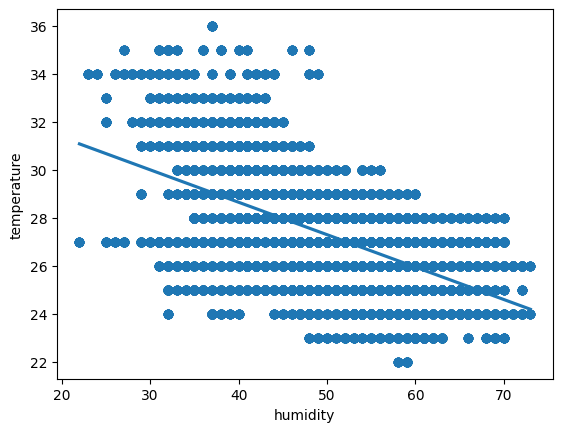

In [111]:
# use the function regplot to make a scatterplot
sns.regplot(x=df_temperature_data["humidity"], y=df_temperature_data["temperature"])
plt.show()

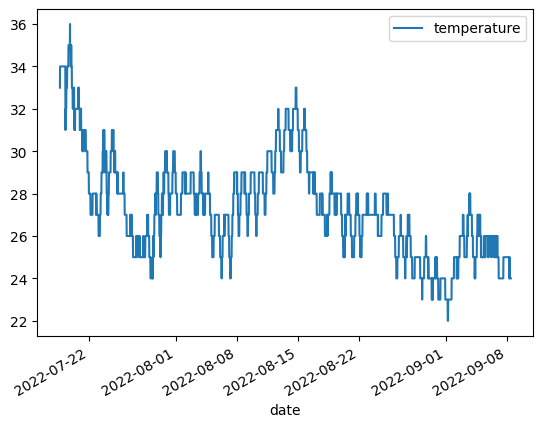

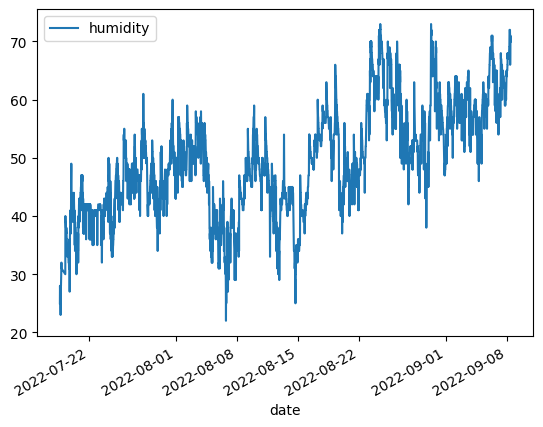

In [112]:
df_temperature_data.plot(x="date", y="temperature")
df_temperature_data.plot(x="date", y="humidity")
plt.show()

<AxesSubplot:xlabel='date'>

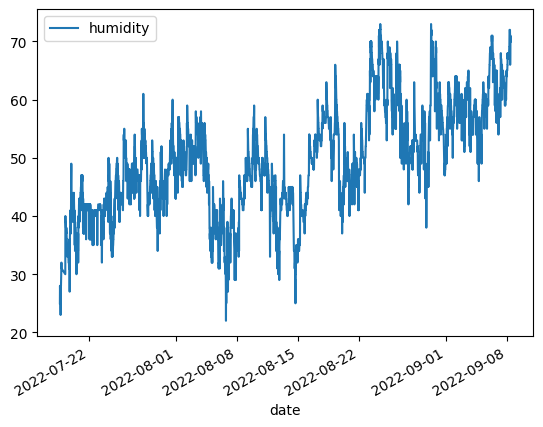

In [113]:
df_temperature_data.plot(x="date", y="humidity")

In [114]:
df_temperature_data.groupby("month").mean()

,year,day,temperature,humidity
month,,,,
7,2022.0,25.273378,28.344519,43.918369
8,2022.0,15.280587,27.450658,49.301129
9,2022.0,4.147842,25.160408,60.288439


In [115]:
# mean grouped by all variables
multi_groupby = list(
    map(lambda x: df_temperature_data.groupby(x).mean(), df_temperature_data.columns)
)
# When print isn't good enough use diaplay for pretty dataframes
for i in multi_groupby:
    display(pd.DataFrame(i))

,year,month,day,temperature,humidity
date,,,,,
2022-07-18 16:48:32.839391,2022.0,7.0,18.0,33.0,25.0
2022-07-18 17:03:33.364782,2022.0,7.0,18.0,34.0,28.0
2022-07-18 17:18:33.890008,2022.0,7.0,18.0,34.0,27.0
2022-07-18 17:48:34.940317,2022.0,7.0,18.0,34.0,28.0
2022-07-18 18:03:35.465421,2022.0,7.0,18.0,34.0,27.0
...,...,...,...,...,...
2022-09-08 09:49:52.193812,2022.0,9.0,8.0,24.0,71.0
2022-09-08 10:04:52.718997,2022.0,9.0,8.0,24.0,71.0
2022-09-08 10:19:53.244101,2022.0,9.0,8.0,24.0,70.0


,month,day,temperature,humidity
year,,,,
2022,7.864721,16.495692,27.404117,49.24508


,year,day,temperature,humidity
month,,,,
7,2022.0,25.273378,28.344519,43.918369
8,2022.0,15.280587,27.450658,49.301129
9,2022.0,4.147842,25.160408,60.288439


,year,month,temperature,humidity
day,,,,
1,2022.0,8.437358,25.869248,54.116629
2,2022.0,8.437358,27.060592,55.088838
3,2022.0,8.432211,27.240218,56.110100
4,2022.0,8.423024,26.885344,51.039760
5,2022.0,8.411625,26.021439,46.385422
6,2022.0,8.411651,25.948002,47.478575
7,2022.0,8.414190,25.884947,47.449664
8,2022.0,8.242796,27.175353,48.154506
9,2022.0,8.000000,28.052083,49.187500


,year,month,day,temperature,humidity
time,,,,,
00:00:02,2022.0,7.0,22.0,29.0,42.0
00:00:24,2022.0,9.0,4.0,26.0,55.0
00:00:41,2022.0,8.0,6.0,26.0,34.0
00:00:54,2022.0,8.0,21.0,27.0,44.0
00:01:21,2022.0,7.0,23.0,27.0,41.0
...,...,...,...,...,...
23:58:50,2022.0,8.0,18.0,28.0,51.0
23:58:52,2022.0,7.0,20.0,31.0,42.0
23:59:21,2022.0,9.0,2.0,27.0,58.0


,year,month,day,humidity
temperature,,,,
22.0,2022.0,9.000000,1.000000,58.800000
23.0,2022.0,8.569431,13.795205,58.885115
24.0,2022.0,8.174620,22.053134,57.057003
25.0,2022.0,8.120199,17.328123,53.041234
26.0,2022.0,7.979773,17.195955,52.098042
27.0,2022.0,7.891453,15.916374,50.436312
28.0,2022.0,7.747216,15.152460,49.202976
29.0,2022.0,7.737004,13.841742,46.429689
30.0,2022.0,7.533701,18.331495,42.819240


,year,month,day,temperature
humidity,,,,
22.0,2022.0,8.000000,6.000000,27.000000
23.0,2022.0,7.000000,18.000000,34.000000
24.0,2022.0,7.000000,18.000000,34.000000
25.0,2022.0,7.800000,11.600000,30.200000
26.0,2022.0,7.500000,12.000000,30.500000
27.0,2022.0,7.513158,11.986842,30.552632
28.0,2022.0,7.166667,17.333333,33.666667
29.0,2022.0,7.844156,10.655844,30.032468
30.0,2022.0,7.733871,12.395161,30.782258
